# Can we use the Federal Prime Lending Rate to predict Mutual Fund Performance?

In [3]:
import yfinance as yf
import pandas as pd
import requests
import pickle
from bs4 import BeautifulSoup
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts

import warnings 


%load_ext autoreload
%matplotlib inline

## Import Yahoo Finance Data on the XLV Fund

In [4]:
xlv = yf.Ticker('XLV')
xlv_hist = xlv.history(period = 'max', actions = False)
xlv_hist['Change'] = xlv_hist['Close'] - xlv_hist['Open']
xlv_hist['Volume'] = xlv_hist.Volume.astype('float64')
xlv_hist.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-12-22,18.41,18.60,18.41,18.58,5700.0,0.17
1998-12-23,18.69,18.99,18.69,18.99,18100.0,0.30
1998-12-24,19.02,19.11,18.94,19.11,4900.0,0.09
1998-12-28,19.05,19.11,18.83,18.83,15500.0,-0.22
1998-12-29,18.83,19.25,18.83,19.25,5300.0,0.42


In [5]:

xlv_hist_monthly = xlv_hist['Close'].resample('MS')
xlv_monthly_mean = pd.DataFrame(xlv_hist_monthly.mean())

xlv_monthly_mean.reindex(index=xlv_monthly_mean.index[::-1])

,Close
Date,
2020-01-01,101.727500
2019-12-01,100.354762
2019-11-01,95.596500
2019-10-01,90.148696
2019-09-01,89.694500
...,...
1999-04-01,21.752857
1999-03-01,20.773913
1999-02-01,20.173684


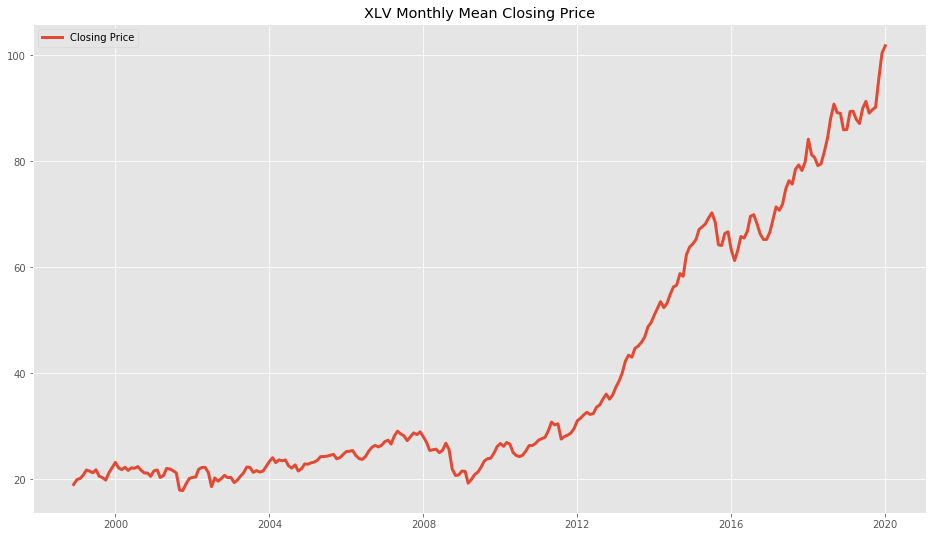

<Figure size 432x288 with 0 Axes>

In [7]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
plt.plot(xlv_monthly_mean, linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show();
plt.savefig('XLV_beginning_close_price')

#There is an upwards Trend

## Perform a Seasonal Decomposition to check for trends, seasonality, and residual distribution

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

In [9]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

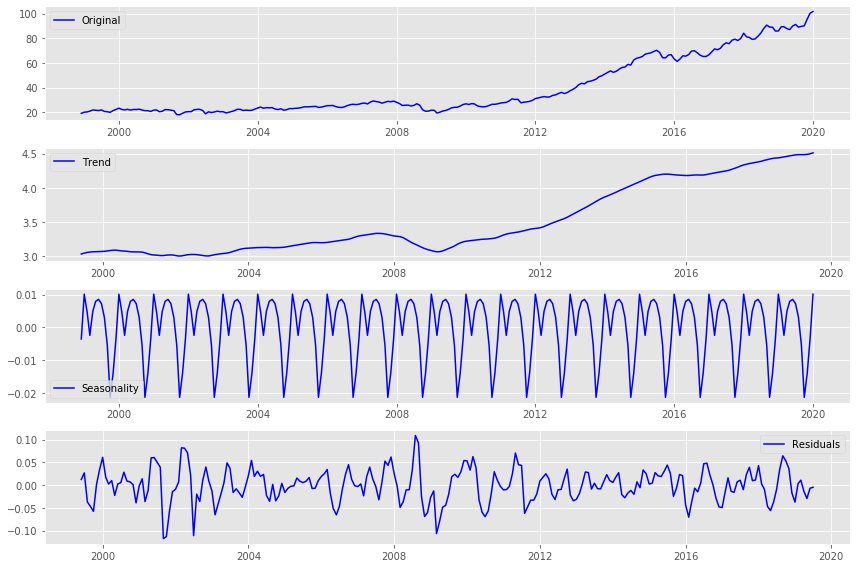

In [10]:
# Original Monthly Mean 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [11]:
#check stationarity
def stationarity_check(TS):
    
    from statsmodels.tsa.stattools import adfuller
    rolmean = TS.rolling(window = 12, center = False).mean()
    rolstd = TS.rolling(window = 12, center = False).std()
    
    dftest = adfuller(TS)
    
    fig = plt.figure(figsize = (16,9))
    orig = plt.plot(TS, color = 'b', label = 'original')
    mean = plt.plot(rolmean, color = 'r', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey-Fuller Test')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    return None

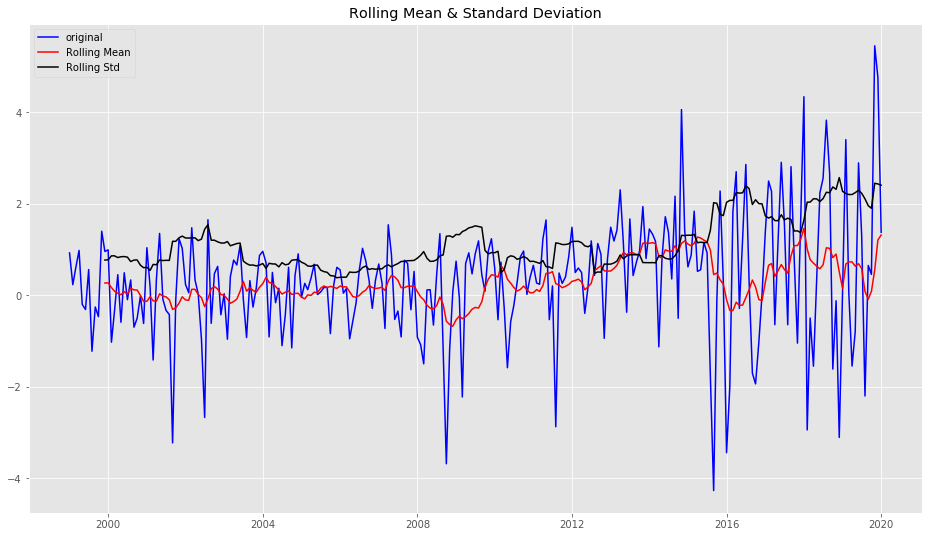

Results of Dickey-Fuller Test
Test Statistic                -1.142847e+01
p-value                        6.605818e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [12]:
#best (first order)
xlv_differenced_mean = xlv_monthly_mean.diff(periods = 1).dropna()
stationarity_check(xlv_differenced_mean.Close)

#### P-val = 7.32e-11 -->  Reject the null hypothesis that the data is not stationary

## ARMA: Auto-Regressive - PACF

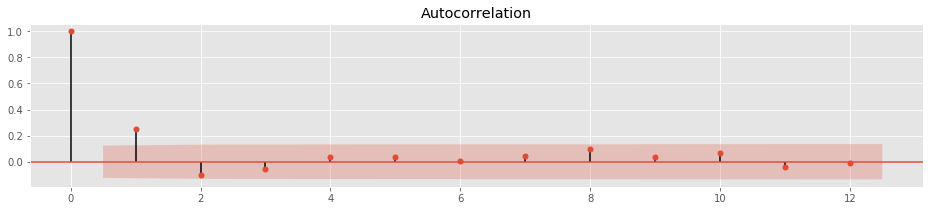

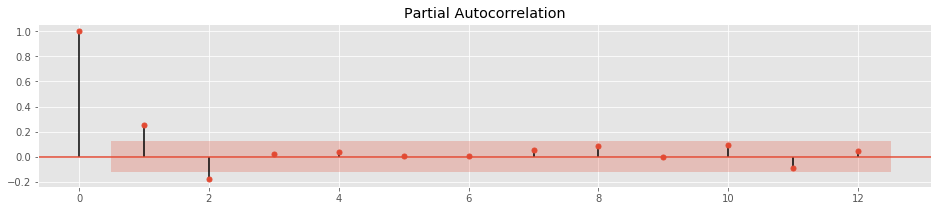

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_differenced_mean, ax = ax, lags = 12);

fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_differenced_mean, ax=ax, lags = 12);

In [17]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,2), seasonal_order=(1,1,2,12));
res = mod.fit();
res.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -408.744
Date:                            Tue, 07 Jan 2020   AIC                            831.488
Time:                                    19:55:30   BIC                            855.882
Sample:                                12-01-1998   HQIC                           841.316
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3063      0.523      0.586      0.558      -0.718       1.331
ma.L1         -0.0089      0.521     -0.017      0.986      -1.031       1.013
ma.L2         -0.2004      0.181     -1.109      0.267      -0.555       0.154
ar.S.L12      -0.9992      0.071    -14.072      0.000      -1.138      -0.860
ma.S.L12       0.1488      0.475      0.314      0.754      -0.781       1.079
ma.S.L24      -0.8320      0.425     -1.957      0.050      -1.665       0.001
sigma2         1.5781      0.643      2.455      0.014       0.318       2.838
===================================================================================
Ljung-Box (Q):                       30.33   Jarque-Bera (JB):                58.06
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.094
Date:                            Tue, 07 Jan 2020   AIC                            834.188
Time:                                    19:55:38   BIC                            851.612
Sample:                                12-01-1998   HQIC                           841.208
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2035      0.172     -1.184      0.236      -0.540       0.133
ma.L1          0.5203      0.161      3.239      0.001       0.205       0.835
ar.S.L12      -0.0763      0.074     -1.026      0.305      -0.222       0.069
ma.S.L12      -0.8340      0.061    -13.622      0.000      -0.954      -0.714
sigma2         1.6750      0.126     13.295      0.000       1.428       1.922
===================================================================================
Ljung-Box (Q):                       33.01   Jarque-Bera (JB):                50.51
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               4.38   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
xlv_monthly_auto = xlv_monthly_mean.copy()

In [20]:
xlv_monthly_mean['Close_P'] = res.predict(start = 225, end = 254, dynamic = False)

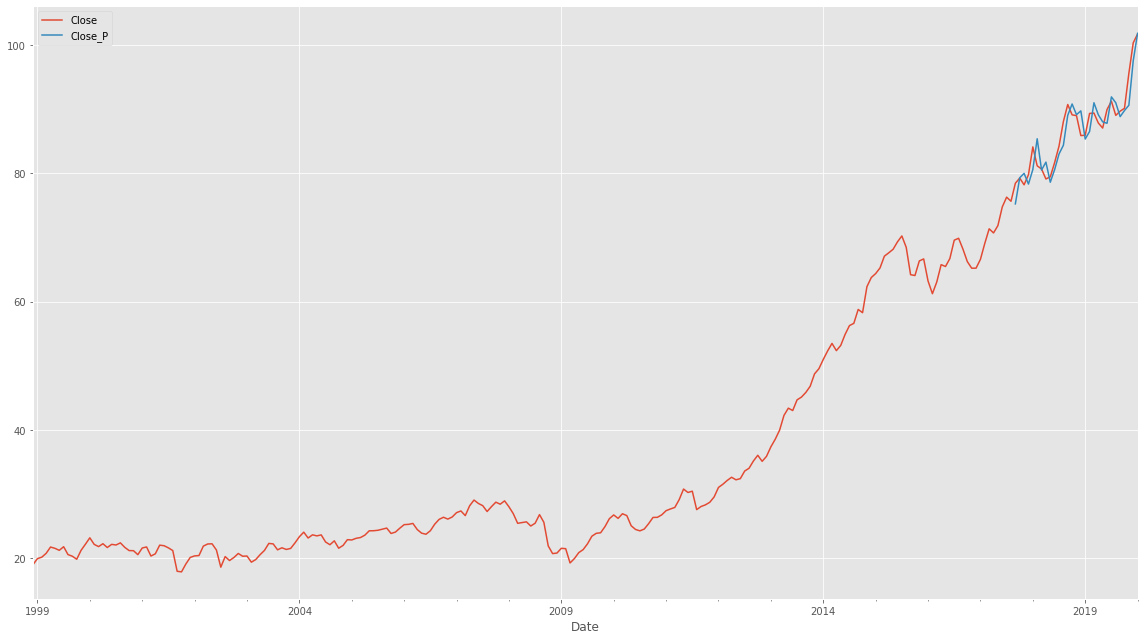

In [28]:
xlv_monthly_mean[['Close', 'Close_P']].plot(figsize = (16,9));
plt.legend(loc = 'upper left')
plt.tight_layout();

In [29]:
xlv_monthly_mean.head()

,Close,Close_P
Date,,
1998-12-01,19.021429,NaN
1999-01-01,19.944737,NaN
1999-02-01,20.173684,NaN
1999-03-01,20.773913,NaN
1999-04-01,21.752857,NaN


In [30]:
from dateutil.relativedelta import relativedelta
import datetime

start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index = date_list, columns = xlv_monthly_mean.columns)
xlv_monthly_mean = pd.concat([xlv_monthly_mean, future])

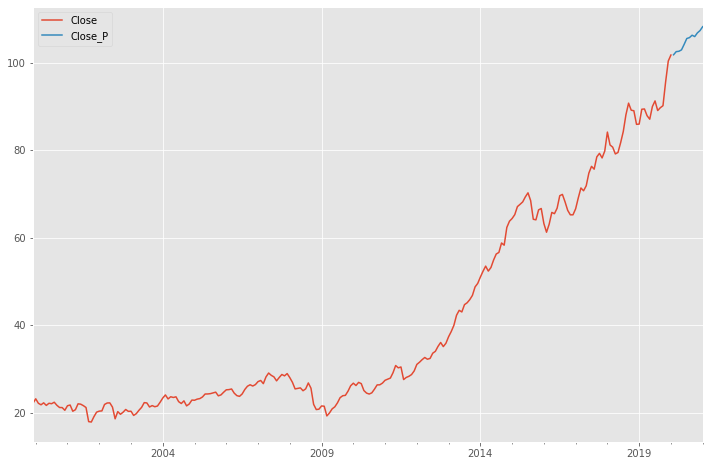

In [31]:
xlv_monthly_mean['Close_P'] = res.predict(start = 254, end = 266, dynamic = True)
xlv_monthly_mean[['Close', 'Close_P']].iloc[-254:].plot(figsize=(12,8))
plt.savefig('XLV_predict_future.png', bbox_inches = 'tight')


### Dynamic Forecasting

In [32]:
prediction = res.get_forecast(steps = 36)
pred_conf = prediction.conf_int()


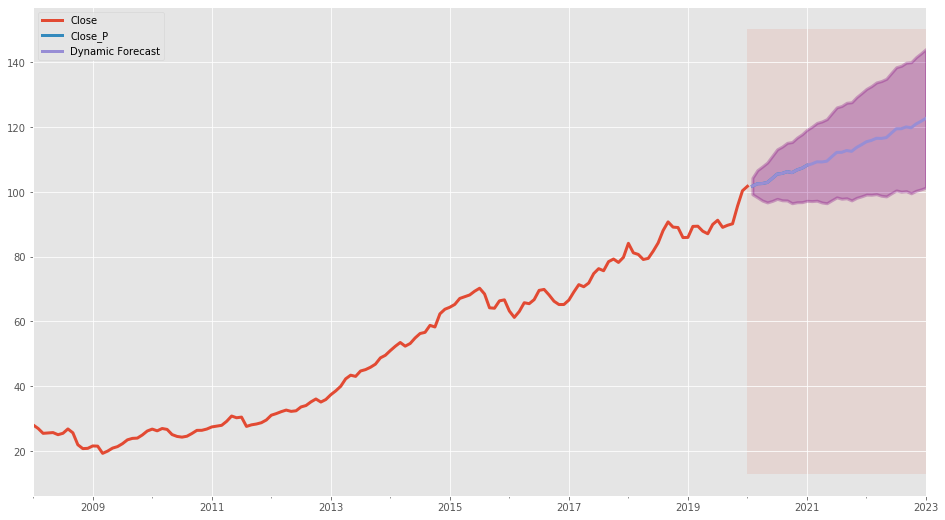

In [36]:
ax = xlv_monthly_mean['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:,0],
                pred_conf.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2023-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.show()

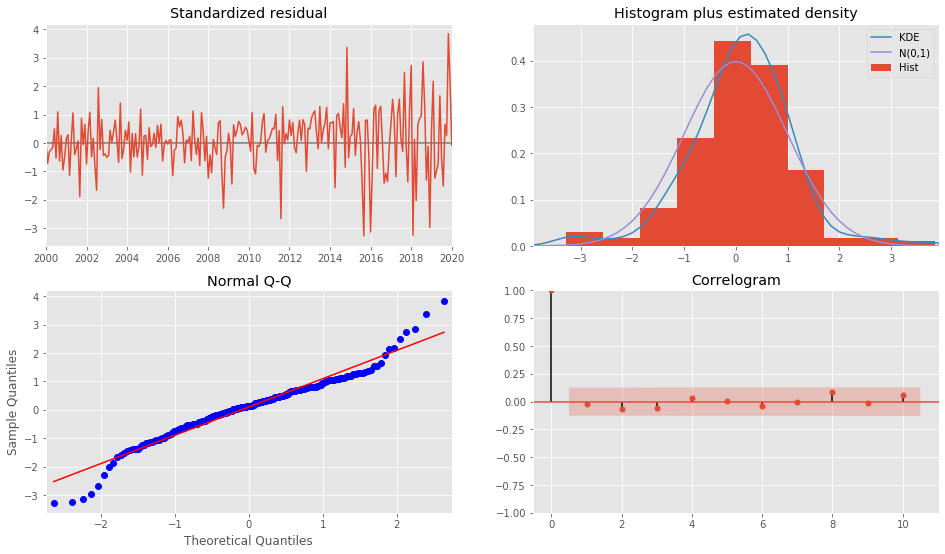

In [37]:
res.plot_diagnostics(figsize = (16,9));

## Auto-ARIMA

In [173]:
# Define the p, d and q parameters to take any value between 0 and 2
import itertools
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))
print(pdq)

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
print(pdqs)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [ ]:

warnings.filterwarnings(action='once')
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean.Close, 
                                            order = comb, 
                                            seasonal_order = combs, 
                                            enforce_stationarity = False, 
                                            enforce_invertability = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {} : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA (0, 0, 0) x (0, 0, 0, 12) : AIC Calculated = 2654.6558191583335
ARIMA (0, 0, 0) x (0, 0, 1, 12) : AIC Calculated = 2278.2803261767426
ARIMA (0, 0, 0) x (0, 0, 2, 12) : AIC Calculated = 1979.4328828605408
ARIMA (0, 0, 0) x (0, 1, 0, 12) : AIC Calculated = 1574.0926653972679
ARIMA (0, 0, 0) x (0, 1, 1, 12) : AIC Calculated = 1458.1686421708473
ARIMA (0, 0, 0) x (0, 1, 2, 12) : AIC Calculated = 1377.5164422927637
ARIMA (0, 0, 0) x (0, 2, 0, 12) : AIC Calculated = 1476.4713184869934
ARIMA (0, 0, 0) x (0, 2, 1, 12) : AIC Calculated = 1333.0330608589234
ARIMA (0, 0, 0) x (0, 2, 2, 12) : AIC Calculated = 1270.1194153484084
ARIMA (0, 0, 0) x (1, 0, 0, 12) : AIC Calculated = 1435.1674644768414
ARIMA (0, 0, 0) x (1, 0, 1, 12) : AIC Calculated = 1430.1082774485424
ARIMA (0, 0, 0) x (1, 0, 2, 12) : AIC Calculated = 1370.874563752644
ARIMA (0, 0, 0) x (1, 1, 0, 12) : AIC Calculated = 1434.8856583935167
ARIMA (0, 0, 0) x (1, 1, 1, 12) : AIC Calculated = 1402.8801923291185
ARIMA (0, 0, 0) x (1,

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (2, 0, 2, 12) : AIC Calculated = 1357.4231255012255
ARIMA (0, 0, 0) x (2, 1, 0, 12) : AIC Calculated = 1359.4384570568116
ARIMA (0, 0, 0) x (2, 1, 1, 12) : AIC Calculated = 1341.4667453678057
ARIMA (0, 0, 0) x (2, 1, 2, 12) : AIC Calculated = 1339.4375298238804
ARIMA (0, 0, 0) x (2, 2, 0, 12) : AIC Calculated = 1285.2119606468636
ARIMA (0, 0, 0) x (2, 2, 1, 12) : AIC Calculated = 1278.123550391847
ARIMA (0, 0, 0) x (2, 2, 2, 12) : AIC Calculated = 1274.7568006115525
ARIMA (0, 0, 1) x (0, 0, 0, 12) : AIC Calculated = 2312.1402048691816


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA (0, 0, 1) x (0, 0, 1, 12) : AIC Calculated = 1954.1822240820477


In [25]:
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 2, 2)
pdqs    (1, 1, 2, 12)
aic           745.377
Name: 716, dtype: object

In [38]:
warnings.filterwarnings(action='once')
Auto_ARIMA = sm.tsa.statespace.SARIMAX(xlv_monthly_auto,
                                       order = (2,2,2),
                                       seasonal_order = (1,1,2,12),
                                       enforce_stationarity = False,
                                       enforce_invertability = False)
output_auto = Auto_ARIMA.fit()
print(output_auto.summary().tables[1])
output_auto.summary()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1709      0.302      0.566      0.571      -0.421       0.763
ar.L2         -0.1997      0.122     -1.636      0.102      -0.439       0.039
ma.L1         -0.8786      0.334     -2.632      0.008      -1.533      -0.224
ma.L2         -0.1192      0.332     -0.359      0.719      -0.769       0.531
ar.S.L12      -0.8417      0.144     -5.827      0.000      -1.125      -0.559
ma.S.L12      -0.1129      0.172     -0.658      0.511      -0.449       0.224
ma.S.L24      -0.6905      0.166     -4.169      0.000      -1.015      -0.366
sigma2         1.6633      0.299      5.566      0.000       1.078       2.249


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood                -364.686
Date:                            Tue, 07 Jan 2020   AIC                            745.373
Time:                                    19:58:41   BIC                            772.263
Sample:                                12-01-1998   HQIC                           756.240
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1709      0.302      0.566      0.571      -0.421       0.763
ar.L2         -0.1997      0.122     -1.636      0.102      -0.439       0.039
ma.L1         -0.8786      0.334     -2.632      0.008      -1.533      -0.224
ma.L2         -0.1192      0.332     -0.359      0.719      -0.769       0.531
ar.S.L12      -0.8417      0.144     -5.827      0.000      -1.125      -0.559
ma.S.L12      -0.1129      0.172     -0.658      0.511      -0.449       0.224
ma.S.L24      -0.6905      0.166     -4.169      0.000      -1.015      -0.366
sigma2         1.6633      0.299      5.566      0.000       1.078       2.249
===================================================================================
Ljung-Box (Q):                       29.04   Jarque-Bera (JB):                51.57
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               5.05   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

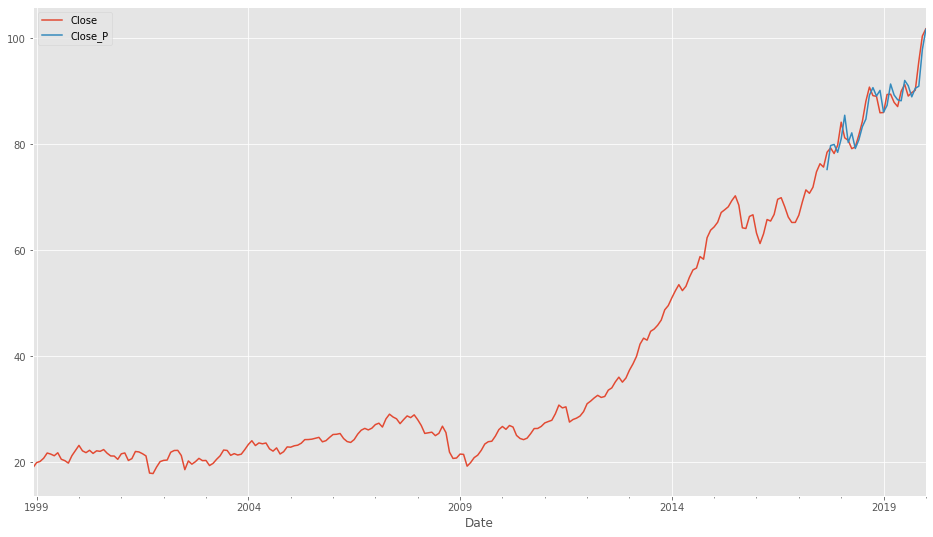

In [39]:
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 225, end = 254, dynamic = False)
xlv_monthly_auto[['Close', 'Close_P']].plot(figsize = (16,9))
plt.legend(loc = 'upper left')
plt.show()


In [40]:
xlv_monthly_auto

,Close,Close_P
Date,,
1998-12-01,19.021429,NaN
1999-01-01,19.944737,NaN
1999-02-01,20.173684,NaN
1999-03-01,20.773913,NaN
1999-04-01,21.752857,NaN
...,...,...
2019-09-01,89.694500,88.902158
2019-10-01,90.148696,90.514268
2019-11-01,95.596500,90.898101


In [41]:
from dateutil.relativedelta import relativedelta
import datetime

start_auto = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
date_list_auto = [start_auto + relativedelta(months=x) for x in range(0,12)]
future_auto = pd.DataFrame(index = date_list_auto, columns = xlv_monthly_auto.columns)
xlv_monthly_auto = pd.concat([xlv_monthly_auto, future_auto])

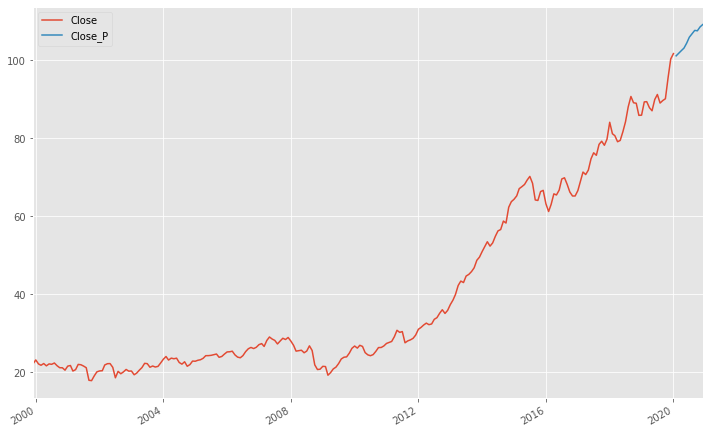

In [43]:
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 254, end = 266, dynamic = True)
xlv_monthly_auto[['Close', 'Close_P']].iloc[-254:].plot(figsize=(12,8))
plt.legend(loc = 'upper left')
plt.show();



In [44]:
prediction_auto = output_auto.get_forecast(steps = 36)
pred_conf_auto = prediction_auto.conf_int()
pred_conf_auto

,lower Close,upper Close
2020-02-01,98.613633,103.692114
2020-03-01,97.656289,105.983509
2020-04-01,97.393194,107.597261
2020-05-01,97.343113,108.947202
2020-06-01,97.966550,110.874616
2020-07-01,98.850424,113.002064
2020-08-01,99.152436,114.466013
2020-09-01,99.479356,115.883240
2020-10-01,98.851932,116.293223
2020-11-01,99.345835,117.782755


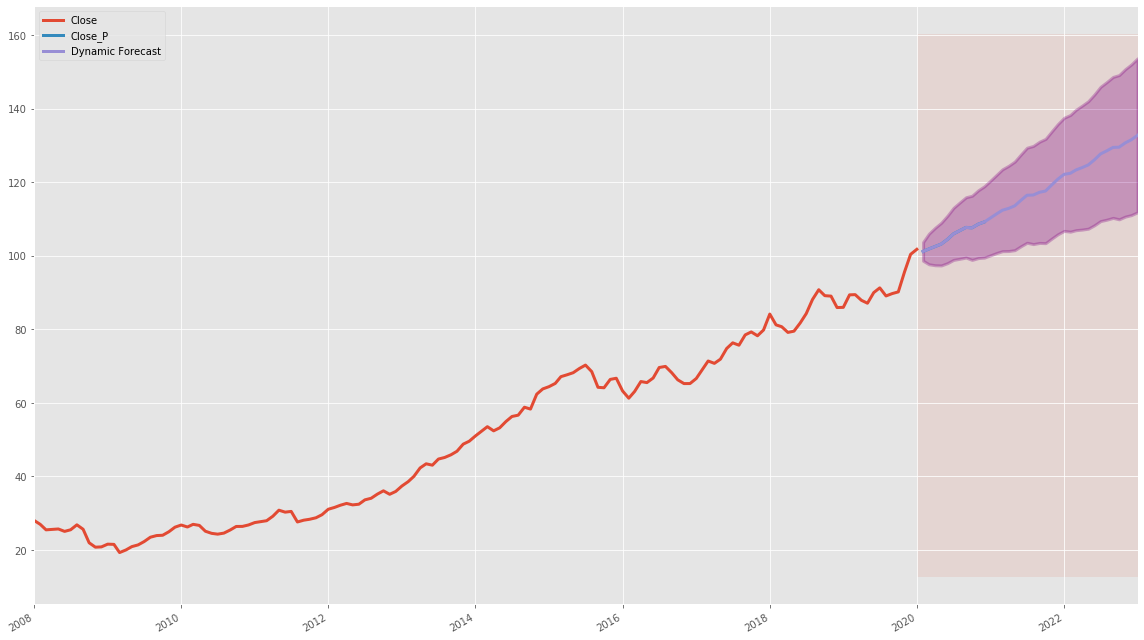

In [47]:
ax = xlv_monthly_auto['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction_auto.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf_auto.index,
                pred_conf_auto.iloc[:,0],
                pred_conf_auto.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2024-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('Auto_ARIMA_Projection.png')
plt.show();
